In [1]:
import sys
sys.path.append('/Users/mnannan/dev/supelec/ngsa/assignments/Assignement 3/src')

In [2]:
import seaborn as sns
sns.set()

In [3]:
from datasets import *

In [4]:
from geometry_matching import *

###### Generate the dataset

Text(0.5, 1.0, 'Example of dataset generated for N =25, sigma=0.01, theta=pi/20, scale=2.0')

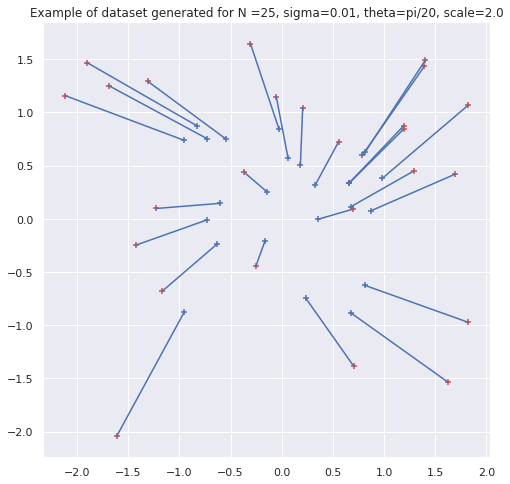

In [5]:
sigma = 1e-2
scaling_factor = 2.0
theta =np.pi/20
N1 = 25
N2 = 25
t = 20 # Number of triangles selected per points in the first dataset
nNN=300 # Number of nearest triangles to extract

points1 = generate_points(N1)
points2 = transform_points(points1, theta, scaling_factor, sigma)

fig = plt.figure(figsize=(8,8))
plt.scatter(points1[:,0], points1[:,1], marker='+', color='b')
plt.scatter(points2[:,0], points2[:, 1], marker='+', color='r')
for (x1,y1), (x2,y2) in zip(points1, points2):
    plt.plot([x1,x2], [y1, y2], color='b')
plt.title(f'Example of dataset generated for N ={N1}, sigma={sigma}, theta=pi/20, scale={scaling_factor}')


###### Extract t triangles per point in the first dataset

In [6]:
triangles1, triangles1_indexes = pick_triangles(points1, t)

###### Extract all the possible triangles that can be built in the second dataset

In [7]:
triangles2 = extract_all_triangles(points2) 

###### Compute associated features for each triangles

In [9]:
features1 = compute_features(triangles1.reshape((-1,3,2)))

features2 = compute_features(triangles2.reshape((-1,3,2))).reshape((N2,N2,N2,3))

# Set features = -10 when triplet of points does draw a triangle (if there are twice the same point)
for i in range(N2):
    for j in range(N2):
        for k in range(N2):
            if i == j or j == k or i == k:
                features2[i, j, k] = -10

###### Extract nNN nearest neighbors for each triangle selected in the first dataset (distance used is the distance between features of each triangles)

In [10]:
nearest_distances, nearest_neighbors = get_closest_features(features1, features2, nNN)

nearest_neighbors_indexes = np.concatenate([
    (nearest_neighbors.reshape((-1,1)) // (N2**2) % N2) ,
    (nearest_neighbors.reshape((-1,1)) // N2)%N2,
    nearest_neighbors.reshape((-1,1)) %  N2] ,axis = 1).reshape((-1,t,nNN,3))

nearest_neighbors = nearest_neighbors.reshape((-1, t, nNN))

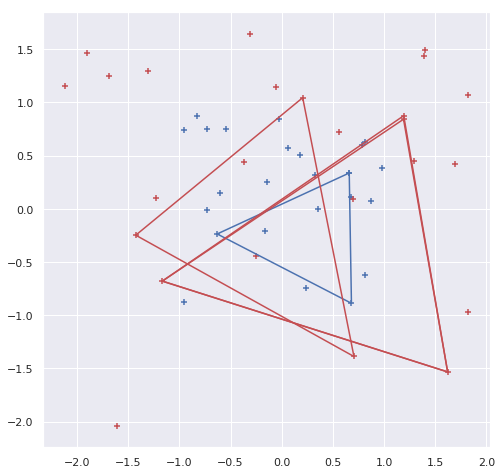

In [11]:
fig = plt.figure(figsize=(8,8))
plt.scatter(points1[:,0], points1[:,1], marker='+')
plt.scatter(points2[:,0], points2[:, 1], marker='+', color='r')
i1 = 2
t1 = 5
for triangle in [triangles1[i1][t1]]:
    for i in range(len(triangle)):
        plt.plot([triangle[i][0], triangle[(i+1)%3][0]],
                 [triangle[i][1], triangle[(i+1)%3][1]], color='b')
nearest_triangles = triangles2.reshape((-1,6))[nearest_neighbors[i1][t1]].reshape((-1,3,2))
for triangle in nearest_triangles[:3]:
    for i in range(len(triangle)):
        plt.plot([triangle[i][0], triangle[(i+1)%3][0]],
                 [triangle[i][1], triangle[(i+1)%3][1]], color='r')


###### Compute potentials (similiraity between triangles from the first dataset and the second one

In [13]:
potentials = np.exp(-(nearest_distances / np.mean(nearest_distances) ))

In [14]:
potentials = potentials.reshape((N1,t,nNN))

###### Run power iteration algorithm one the potential to extract the mapping 

In [15]:
mapping = power_iteration(triangles1_indexes, nearest_neighbors_indexes, potentials, N1, N2)

Epoch 1
||Vn - Vn_1|| = 24.02084548460121
Epoch 2
||Vn - Vn_1|| = 0.12348201484986146
Epoch 3
||Vn - Vn_1|| = 0.013729121032561551
Epoch 4
||Vn - Vn_1|| = 0.0038702556909160197
Epoch 5
||Vn - Vn_1|| = 0.001280696859226128
Epoch 6
||Vn - Vn_1|| = 0.00043338667694533303
Epoch 7
||Vn - Vn_1|| = 0.0001472222588172551
Epoch 8
||Vn - Vn_1|| = 5.0049691378050115e-05
Epoch 9
||Vn - Vn_1|| = 1.701770504687944e-05
Epoch 10
||Vn - Vn_1|| = 5.786520910825986e-06
Stop after 9 iterations


In [16]:
def plot_solution(points1, points2, mapping):
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points1[:,0], points1[:,1], marker='+')
    plt.scatter(points2[mapping][:,0], points2[mapping][:, 1], marker='+', color='r')
    for (x1,y1), (x2,y2) in zip(points1, points2[mapping]):
        plt.plot([x1,x2], [y1, y2], color='b')
    for (x1,y1), (x2,y2) in zip(points1, points2):
        plt.plot([x1,x2], [y1, y2], color='r')



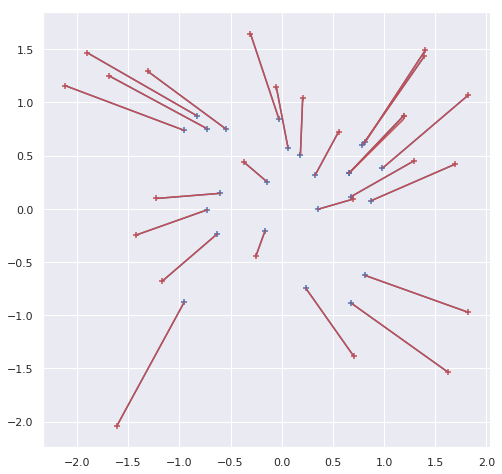

In [17]:
plot_solution(points1, points2, mapping)

In [18]:
print(f'Good match : {np.argwhere(mapping == np.arange(0, N1)).shape[0]}/{N1}')

Good match : 24/25


In [19]:
mapping

array([ 0,  1, 13,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])